In [2]:
# We will need the RBCPath type from the rbclib package to load data from the RBC.
from rbclib import RBCPath

# We'll also want to load some data directly from the filesystem.
from pathlib import Path

# We'll want to load/process some of the data using pandas and numpy.
import pandas as pd
import numpy as np

In [3]:
# Participant meta-data is generally located in the BIDS repository for each
# study:
rbcdata_path = Path('/home/jovyan/shared/data/RBC')
train_filepath = rbcdata_path / 'train_participants.tsv'
test_filepath = rbcdata_path / 'test_participants.tsv'

# Load the PNC participants TSV files...
with train_filepath.open('r') as f:
    train_data = pd.read_csv(f, sep='\t')
with test_filepath.open('r') as f:
    test_data = pd.read_csv(f, sep='\t')

# We can also concatenate the two datasets into a single dataset of all
# study participants:
all_data = pd.concat([train_data, test_data])

# Display the full dataframe:
all_data

,participant_id,study,study_site,session_id,wave,age,sex,race,ethnicity,bmi,handedness,participant_education,parent_1_education,parent_2_education,p_factor,internalizing_mcelroy_harmonized_all_samples,externalizing_mcelroy_harmonized_all_samples,attention_mcelroy_harmonized_all_samples,cubids_acquisition_group
0,1000393599,PNC,PNC1,PNC1,1,15.583333,Male,Black,not Hispanic or Latino,22.15,Right,9th Grade,Complete primary,Complete secondary,0.589907,-0.449373,-0.630780,-1.842178,1
1,1001970838,PNC,PNC1,PNC1,1,17.833333,Male,Other,Hispanic or Latino,23.98,Right,11th Grade,Complete tertiary,Complete tertiary,-0.659061,0.531072,0.392751,0.190706,1
2,1007995238,PNC,PNC1,PNC1,1,13.750000,Female,Other,not Hispanic or Latino,23.77,Right,6th Grade,Complete tertiary,Complete primary,-1.608375,-0.744118,-0.314187,-0.432662,1
3,1011497669,PNC,PNC1,PNC1,1,16.666667,Male,White,not Hispanic or Latino,29.68,Right,9th Grade,Complete tertiary,Complete tertiary,-1.233807,-0.896835,-0.449099,0.111167,1
4,1017092387,PNC,PNC1,PNC1,1,18.666667,Female,Black,not Hispanic or Latino,23.24,Right,11th Grade,Complete primary,Complete primary,-0.923100,-0.313455,2.204168,-0.782266,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,969649154,PNC,PNC1,PNC1,1,12.333333,Male,White,not Hispanic or Latino,17.38,Right,5th Grade,Complete tertiary,Complete secondary,NaN,-0.148520,0.556444,0.024228,1
530,970890500,PNC,PNC1,PNC1,1,18.166667,Female,White,not Hispanic or Latino,30.89,Right,11th Grade,Complete secondary,Complete secondary,NaN,0.993806,1.578177,-0.373470,1
531,975856179,PNC,PNC1,PNC1,1,11.000000,Male,White,not Hispanic or Latino,15.67,Right,4th Grade,Complete primary,Complete secondary,NaN,-1.026645,-0.582212,1.333857,1
532,984757368,PNC,PNC1,PNC1,1,13.416667,Male,Black,not Hispanic or Latino,16.66,Right,5th Grade,Complete primary,NaN,NaN,0.360029,-0.515655,1.509584,114


In [4]:
def load_fsdata(participant_id, local_cache_dir=(Path.home() / 'cache')):
    "Loads and returns the dataframe of a PNC participant's FreeSurfer data."

    # Check that the local_cache_dir exists and make it if it doesn't.
    if local_cache_dir is not None:
        local_cache_dir = Path(local_cache_dir)
        local_cache_dir.mkdir(exist_ok=True)
    
    # Make the RBCPath and find the appropriate file:
    pnc_freesurfer_path = RBCPath(
        'rbc://PNC_FreeSurfer/freesurfer',
        # We provide the local_cache_dir to the RBCPath object; all paths made
        # from this object will use the same cache directory.
        local_cache_dir=local_cache_dir)
    participant_path = pnc_freesurfer_path / f'sub-{participant_id}'
    tsv_path = participant_path / f'sub-{participant_id}_regionsurfacestats.tsv'

    # Use pandas to read in the TSV file:
    with tsv_path.open('r') as f:
        data = pd.read_csv(f, sep='\t')

    # Return the loaded data:
    return data

In [5]:
# Check that no duplicant participant IDs are present in the all_data dataframe.
all_data[all_data['participant_id'].duplicated()]

,participant_id,study,study_site,session_id,wave,age,sex,race,ethnicity,bmi,handedness,participant_education,parent_1_education,parent_2_education,p_factor,internalizing_mcelroy_harmonized_all_samples,externalizing_mcelroy_harmonized_all_samples,attention_mcelroy_harmonized_all_samples,cubids_acquisition_group


In [7]:
# Load FreeSurfer data for all participants in the all_data dataframe.

participant_list = all_data['participant_id']
num_participants = len(participant_list)
print(f"Number of participants: {num_participants}")

data = []
i = 0

for participant in participant_list:
    try:
        subj_data = load_fsdata(participant)
        print(type(subj_data), subj_data.shape, participant)
        data.append(subj_data)
    except FileNotFoundError:
        print(f"Skipping {participant}: file not found.")
    print(f"Processed {i+1}/{num_participants} participants.")
    i += 1

data = pd.concat(data, ignore_index=True)

data

Number of participants: 1601
<class 'pandas.core.frame.DataFrame'> (13740, 27) 1000393599
Processed 1/1601 participants.
<class 'pandas.core.frame.DataFrame'> (13743, 27) 1001970838
Processed 2/1601 participants.
<class 'pandas.core.frame.DataFrame'> (13739, 27) 1007995238
Processed 3/1601 participants.
<class 'pandas.core.frame.DataFrame'> (13739, 27) 1011497669
Processed 4/1601 participants.
<class 'pandas.core.frame.DataFrame'> (13742, 27) 1017092387
Processed 5/1601 participants.
<class 'pandas.core.frame.DataFrame'> (13741, 27) 1020132225
Processed 6/1601 participants.
<class 'pandas.core.frame.DataFrame'> (13738, 27) 1023701836
Processed 7/1601 participants.
<class 'pandas.core.frame.DataFrame'> (13743, 27) 1025031408
Processed 8/1601 participants.
<class 'pandas.core.frame.DataFrame'> (13737, 27) 1027389114
Processed 9/1601 participants.
<class 'pandas.core.frame.DataFrame'> (13702, 27) 1037644062
Processed 10/1601 participants.
<class 'pandas.core.frame.DataFrame'> (13742, 27) 

,subject_id,session_id,atlas,hemisphere,StructName,NumVert,SurfArea,GrayVol,ThickAvg,ThickStd,...,StdDev_wgpct,Min_wgpct,Max_wgpct,Range_wgpct,SNR_wgpct,Mean_piallgi,StdDev_piallgi,Min_piallgi,Max_piallgi,Range_piallgi
0,sub-1000393599,NaN,aparc.DKTatlas,lh,caudalanteriorcingulate,1668,1121,3493,2.870,0.588,...,5.8371,-1.8413,42.8855,44.7269,4.4281,1.9877,0.0777,1.8054,2.1455,0.3402
1,sub-1000393599,NaN,aparc.DKTatlas,lh,caudalmiddlefrontal,3308,2236,7030,2.882,0.537,...,4.6666,7.1531,40.4774,33.3243,5.0341,3.3898,0.2448,2.7003,3.8032,1.1029
2,sub-1000393599,NaN,aparc.DKTatlas,lh,cuneus,4102,2619,5753,2.019,0.490,...,5.2623,-13.1617,33.8137,46.9754,3.0343,3.2453,0.3093,2.4099,3.5491,1.1392
3,sub-1000393599,NaN,aparc.DKTatlas,lh,entorhinal,737,549,2714,3.655,0.585,...,6.0438,2.5989,37.5099,34.9110,3.4560,2.6710,0.1285,2.4654,2.9647,0.4993
4,sub-1000393599,NaN,aparc.DKTatlas,lh,fusiform,4115,2822,8180,2.738,0.526,...,5.2854,-5.9378,39.6908,45.6286,3.9405,2.8272,0.1093,2.3304,3.1105,0.7800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21870027,sub-987544292,NaN,Yeo2011_7Networks_N1000,rh,7Networks_3,12082,8140,21362,2.523,0.463,...,5.2509,0.1926,47.1000,46.9074,4.4612,3.0664,0.3446,2.4856,4.4953,2.0097
21870028,sub-987544292,NaN,Yeo2011_7Networks_N1000,rh,7Networks_4,12738,8524,28460,2.947,0.609,...,6.6545,-14.8906,41.1515,56.0421,3.4465,3.4085,0.9096,1.9190,4.9617,3.0427
21870029,sub-987544292,NaN,Yeo2011_7Networks_N1000,rh,7Networks_5,10373,7220,26768,2.982,0.802,...,8.4700,-92.5620,87.2122,179.7742,2.7419,2.5130,0.3160,2.0978,4.5604,2.4625
21870030,sub-987544292,NaN,Yeo2011_7Networks_N1000,rh,7Networks_6,20904,14055,43294,2.723,0.660,...,6.0907,-16.1204,40.9862,57.1066,3.9056,3.0289,0.4640,1.9037,4.5032,2.5996


In [8]:
demo_behav_data = list(all_data.columns) 
brain_data = list(data.columns)

print("Demographic and behavioral data columns:", demo_behav_data)
print("Brain data: ", brain_data)

Demographic and behavioral data columns: ['participant_id', 'study', 'study_site', 'session_id', 'wave', 'age', 'sex', 'race', 'ethnicity', 'bmi', 'handedness', 'participant_education', 'parent_1_education', 'parent_2_education', 'p_factor', 'internalizing_mcelroy_harmonized_all_samples', 'externalizing_mcelroy_harmonized_all_samples', 'attention_mcelroy_harmonized_all_samples', 'cubids_acquisition_group']
Brain data:  ['subject_id', 'session_id', 'atlas', 'hemisphere', 'StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd', 'Index', 'SegId', 'Mean_wgpct', 'StdDev_wgpct', 'Min_wgpct', 'Max_wgpct', 'Range_wgpct', 'SNR_wgpct', 'Mean_piallgi', 'StdDev_piallgi', 'Min_piallgi', 'Max_piallgi', 'Range_piallgi']


In [9]:
#Select a specific atlas to work with (would one be better than another?)
atlas = 'Schaefer2018_200Parcels_7Networks_order'  

In [15]:
# Keep only the necessary columns for the selected atlas
single_atlas_data = data[data['atlas'] == atlas][['subject_id','session_id', 'hemisphere','StructName','NumVert', 'Index','SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv','GausCurv', 'FoldInd', 'CurvInd','Mean_wgpct','Mean_piallgi']]

In [19]:
# Get rid of first row because it is not a brain region (background + FS defined medial wall)
single_atlas_data = single_atlas_data[single_atlas_data['Index'] != 1]

In [ ]:
def flatten_with_region_labels(df):
    # Keep the subject ID
    subj_id = df['subject_id'].iloc[0]

    # Features to rename (everything except these)
    exclude = {'subject_id', 'session_id', 'hemisphere', 'Index'}
    feature_cols = [col for col in df.columns if col not in exclude]

    flat_data = {}
    flat_data['subject_id'] = subj_id
    for _, row in df.iterrows():
        hemi = row['hemisphere']
        idx = str(row['Index'])
        for feat in feature_cols:
            new_col = f"{feat}_{hemi}_{idx}"
            flat_data[new_col] = row[feat]

    return pd.DataFrame([flat_data])

In [22]:
def flatten_all_subjects(df):
    flat_list = []
    for subj_id, subj_df in df.groupby('subject_id'):
        flat = flatten_with_region_labels(subj_df)
        flat_list.append(flat)
    return pd.concat(flat_list, ignore_index=True)

In [23]:
flatten_all_subjects(single_atlas_data)

,subject_id,StructName_lh_2,NumVert_lh_2,SurfArea_lh_2,GrayVol_lh_2,ThickAvg_lh_2,ThickStd_lh_2,MeanCurv_lh_2,GausCurv_lh_2,FoldInd_lh_2,...,SurfArea_rh_101,GrayVol_rh_101,ThickAvg_rh_101,ThickStd_rh_101,MeanCurv_rh_101,GausCurv_rh_101,FoldInd_rh_101,CurvInd_rh_101,Mean_wgpct_rh_101,Mean_piallgi_rh_101
0,sub-1000393599,7Networks_LH_Vis_1,1105,770,2070,2.604,0.600,0.129,0.024,14,...,688,2060,2.458,0.513,0.142,0.029,15,1.2,20.6351,2.9065
1,sub-1000881804,7Networks_LH_Vis_1,1279,857,2281,2.472,0.533,0.125,0.024,18,...,628,2107,2.741,0.476,0.143,0.034,15,1.3,21.5335,3.0924
2,sub-1001970838,7Networks_LH_Vis_1,1327,869,2085,2.210,0.459,0.126,0.034,20,...,592,1874,2.518,0.554,0.144,0.033,15,1.2,22.3422,3.0894
3,sub-100527940,7Networks_LH_Vis_1,1072,758,2115,2.668,0.490,0.113,0.021,13,...,620,2446,2.935,0.666,0.156,0.047,23,1.9,19.4762,3.1609
4,sub-1006151876,7Networks_LH_Vis_1,1054,694,1731,2.432,0.424,0.135,0.025,16,...,553,1795,2.624,0.597,0.149,0.031,16,1.1,21.7938,2.7393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,sub-985910486,7Networks_LH_Vis_1,1104,749,1791,2.361,0.481,0.118,0.027,13,...,476,1404,2.499,0.541,0.157,0.036,14,0.8,21.0914,2.9002
1588,sub-986035435,7Networks_LH_Vis_1,1090,743,2165,2.750,0.486,0.116,0.024,12,...,680,2478,2.816,0.658,0.136,0.033,17,1.1,22.3093,3.1900
1589,sub-987544292,7Networks_LH_Vis_1,1132,780,2220,2.748,0.503,0.118,0.022,13,...,811,2154,2.415,0.506,0.139,0.034,19,1.5,22.3878,2.9748
1590,sub-993394555,7Networks_LH_Vis_1,1254,847,2545,2.871,0.421,0.121,0.027,14,...,701,2464,2.764,0.482,0.139,0.029,17,1.3,20.9378,2.8220


### Step 2. Train the Linear Regression

To train and perform the linear regression analysis, we will use the
[`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
type from scikit-learn.

In [69]:
# Import the LinearRegression type:
from sklearn.linear_model import LinearRegression

# LinearRegression requires a matrix whose columns are the variables and whose
# final column is the value being predicted (the p_factor for us). We can
# extract these columns straight from the dataframes we generated.
train_matrix = train_vars.loc[:, ['ba1_surface_area', 'p_factor']].values
# We need to exclude rows with NaNs for training:
train_okrows = np.all(~np.isnan(train_matrix), axis=1)
train_matrix = train_matrix[train_okrows]

# Train the regression using the training matrix:
lreg = LinearRegression()
lreg.fit(train_matrix[:, :1], train_matrix[:, 1])

# Display the trained regression parameters:
print("Linear Regression:")
print("  Intercept:", lreg.intercept_)
print("  Slope:", lreg.coef_)

NameError: name 'train_vars' is not defined

### Step 3. Predict the `p_factor` of the Test Data

In [ ]:
# We can apply the trained linear regression object `lreg` to the 1-column
# matrix of ba1_surface_area values in the test_vars dataframe.
test_matrix = test_vars.loc[:, ['ba1_surface_area']].values
test_okrows = np.all(~np.isnan(test_matrix), axis=1)
test_matrix = test_matrix[test_okrows]

# Apply the model:
p_factor_predictions = lreg.predict(test_matrix)

# Display the predictions:
p_factor_predictions

array([-0.42986345, -0.41645609, -0.30982084, -0.66620708, -0.2929837 ,
       -0.3849644 , -0.37685762, -0.39587736, -0.49066425, -0.47039732,
       -0.48380467, -0.48162208, -0.54522907, -0.52122055, -0.42830445,
       -0.29672528, -0.52090875, -0.5673668 , -0.45948435, -0.4454534 ,
       -0.48505187, -0.37872842, -0.24122507, -0.43797022, -0.44015282,
       -0.38091101, -0.55614204, -0.34380693, -0.40523133, -0.46634393,
       -0.40897292, -0.31917481, -0.39431837, -0.60540628, -0.3846526 ,
       -0.52963912, -0.48286928, -0.5364987 , -0.40304874, -0.55770103,
       -0.65591771, -0.37405143, -0.44950679, -0.37623402, -0.29828428,
       -0.26367459, -0.48318108, -0.36407386, -0.51747896, -0.49752383,
       -0.42861625, -0.48567547, -0.45013038, -0.46852652, -0.50313621,
       -0.32011021, -0.4142735 , -0.44202361, -0.35690249, -0.55551844,
       -0.56892579, -0.62130802, -0.59480511, -0.5053188 , -0.38153461,
       -0.49347044, -0.60914786, -0.46416134, -0.32042201, -0.51

### Step 4. Save and Commit the Results

To save and commit the results, we first need to save the predicted `p_factor`
data into the test dataframe (where there are currently NaNs). In the cell
above, we calculated the variable `test_okrows` that indicates which rows
of the `test_vars`, `test_matrix`, and `test_data` objects were predicted
(those that weren't predicted were excluded due to missing surface area data
in our case).

We can use this to insert the predicted `p_factor` data into `test_data`.

In [ ]:
test_data.loc[test_okrows, 'p_factor'] = p_factor_predictions

# Display the resulting test data:
test_data

,participant_id,study,study_site,session_id,wave,age,sex,race,ethnicity,bmi,handedness,participant_education,parent_1_education,parent_2_education,p_factor,internalizing_mcelroy_harmonized_all_samples,externalizing_mcelroy_harmonized_all_samples,attention_mcelroy_harmonized_all_samples,cubids_acquisition_group
0,1000881804,PNC,PNC1,PNC1,1,14.916667,Male,Black,not Hispanic or Latino,21.52,Right,7th Grade,Complete secondary,Complete secondary,-0.429863,0.097355,0.387355,-0.467807,113
1,100527940,PNC,PNC1,PNC1,1,8.250000,Male,Black,not Hispanic or Latino,NaN,Ambidextrous,1st Grade,Complete secondary,Complete primary,-0.416456,0.699062,-0.781881,-0.982040,3
2,1006151876,PNC,PNC1,PNC1,1,21.500000,Female,Other,not Hispanic or Latino,NaN,Right,12th Grade,Complete tertiary,Complete secondary,-0.309821,0.495947,0.806481,-0.832210,1
3,1012530688,PNC,PNC1,PNC1,1,8.750000,Male,Black,not Hispanic or Latino,21.36,Right,2nd Grade,Complete tertiary,Complete secondary,-0.666207,-0.334835,1.277773,0.161110,4
4,1030193285,PNC,PNC1,PNC1,1,18.000000,Male,White,not Hispanic or Latino,22.15,Right,10th Grade,Complete secondary,Complete primary,-0.292984,1.027404,-0.490472,2.014568,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,969649154,PNC,PNC1,PNC1,1,12.333333,Male,White,not Hispanic or Latino,17.38,Right,5th Grade,Complete tertiary,Complete secondary,-0.532445,-0.148520,0.556444,0.024228,1
530,970890500,PNC,PNC1,PNC1,1,18.166667,Female,White,not Hispanic or Latino,30.89,Right,11th Grade,Complete secondary,Complete secondary,-0.267104,0.993806,1.578177,-0.373470,1
531,975856179,PNC,PNC1,PNC1,1,11.000000,Male,White,not Hispanic or Latino,15.67,Right,4th Grade,Complete primary,Complete secondary,-0.462914,-1.026645,-0.582212,1.333857,1
532,984757368,PNC,PNC1,PNC1,1,13.416667,Male,Black,not Hispanic or Latino,16.66,Right,5th Grade,Complete primary,NaN,-0.467279,0.360029,-0.515655,1.509584,114


We now need to save the data to disk. We want to put this in the `results`
directory of the repository.

In [ ]:
# The sep='\t' option here is necessary for tab-separated-value (as opposed to
# comma-separated-value) files. The `index=False` just indicates that pandas
# doesn't need to write out its own index column.

group_name = 'example'  # Change this to be your group name!

test_data.to_csv(f'results/{group_name}.tsv', sep='\t', index=False)

Once the tsv file has been saved, you can commit it to your GitHub repository
then push it and submit a pull request to the `results` branch of the original
repository!

### Since a wide variety of brain atlases were included, a random atlas would be picked below: 'Schaefer2018_200Parcels_7Networks_order'

### Data Organization

In [ ]:
def flatten_with_region_labels(df):
    # Keep the subject ID
    subj_id = df['subject_id'].iloc[0]

    # Features to rename (everything except these)
    exclude = {'subject_id', 'hemisphere', 'Index'}
    feature_cols = [col for col in df.columns if col not in exclude]

    flat_data = {}
    flat_data['subject_id'] = subj_id
    for _, row in df.iterrows():
        hemi = row['hemisphere']
        idx = str(row['Index'])
        for feat in feature_cols:
            new_col = f"{feat}_{hemi}_{idx}"
            flat_data[new_col] = row[feat]

    return pd.DataFrame([flat_data])

In [ ]:
def load_surfarea(participant_id):
    """Loads and returns the bilateral Brodmann Area 1 surface area for a PNC
    study participant.
    """
    # First, load the subject's FreeSurfer dataframe:
    data = load_fsdata(participant_id)
    # Next, find the relevant rows:
    row_mask = (data[data['atlas'] == 'Schaefer2018_200Parcels_7Networks_order'][['subject_id','hemisphere','Index','SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv','GausCurv', 'FoldInd', 'CurvInd','Mean_wgpct','Mean_piallgi']])
    row_mask = row_mask[row_mask['Index'] != 1] ## remove Background+FreeSurfer_Defined_Medial_Wall
    # Then extract and sum the surface areas:
    surfareas = flatten_with_region_labels(row_mask)
    # And return this value:
    return surfareas

In [ ]:
# First load in surface area data for each participant:
print("Loading surface areas...")     

# We will put the rows in this dictionary of lists as we build the dataframe:
# all_vars = {
#     'participant_id': [],
#     'ba1_surface_area': [],
#     'p_factor': []}

# We'll display a progress bar `prog` as we go also:
from ipywidgets import IntProgress
prog = IntProgress(min=0, max=len(all_data))
display(prog)
data_train_test_200 = pd.DataFrame()

# Okay, loop through each row of the `all_data` dataframe, which contains both
# training and test subjects, load their BA1 data, and store it in the
# all_vars dictionary.
for (ii, row) in all_data.iterrows():
    # Extract the participant ID and p_factor (which will be NaN for test
    # participants).
    participant_id = row['participant_id']
    p_factor = row['p_factor']
    age = row['age']
    sex = row['sex']
    bmi = row['bmi']

    # Load the surface area for this participant:
    try:
        surf_area = load_surfarea(participant_id)
    except FileNotFoundError:
        # Some subjects are just missing the file, so we code them as NaN. ## we skip them here
        # surf_area = np.nan
        print(f"Skipping {participant_id}: file not found.")
        continue
    # Append the participant ID and their surface area to our dataset:
    # all_vars['participant_id'].append(participant_id)
    # all_vars['ba1_surface_area'].append(surf_area)
    # all_vars['p_factor'].append(p_factor)
    surf_area['p_factor'] = p_factor
    ## add some relevent demographic variables
    surf_area['age'] = age
    surf_area['sex'] = sex
    surf_area['bmi'] = bmi

    data_train_test_200 = pd.concat([data_train_test_200, surf_area], ignore_index=True)

    # Increment the progress bar counter:
    prog.value += 1

# Convert train_vars into a dataframe.
# all_vars = pd.DataFrame(all_vars)

# Extract the training and test subjects into separate dataframes; the test
# participants can be identified as those having NaN values for their
# p_factor column.
train_vars = data_train_test_200[~np.isnan(data_train_test_200['p_factor'])]
test_vars = data_train_test_200[np.isnan(data_train_test_200['p_factor'])]

# Display the finished dataframe.
data_train_test_200

Loading surface areas...


IntProgress(value=0, max=1601)

Skipping 1342487188: file not found.
Skipping 1649551035: file not found.
Skipping 2003542642: file not found.
Skipping 219325366: file not found.
Skipping 2249226316: file not found.
Skipping 4184549693: file not found.
Skipping 495793681: file not found.
Skipping 4205323727: file not found.
Skipping 533698126: file not found.


,subject_id,SurfArea_lh_2,GrayVol_lh_2,ThickAvg_lh_2,ThickStd_lh_2,MeanCurv_lh_2,GausCurv_lh_2,FoldInd_lh_2,CurvInd_lh_2,Mean_wgpct_lh_2,...,MeanCurv_rh_101,GausCurv_rh_101,FoldInd_rh_101,CurvInd_rh_101,Mean_wgpct_rh_101,Mean_piallgi_rh_101,p_factor,age,sex,bmi
0,sub-1000393599,770,2070,2.604,0.600,0.129,0.024,14,1.1,19.3572,...,0.142,0.029,15,1.2,20.6351,2.9065,0.589907,15.583333,Male,22.15
1,sub-1001970838,869,2085,2.210,0.459,0.126,0.034,20,1.6,18.7546,...,0.144,0.033,15,1.2,22.3422,3.0894,-0.659061,17.833333,Male,23.98
2,sub-1007995238,795,2252,2.787,0.508,0.104,0.021,15,1.0,21.3145,...,0.138,0.032,18,1.3,22.1665,3.1822,-1.608375,13.750000,Female,23.77
3,sub-1011497669,848,2420,2.687,0.452,0.116,0.024,13,1.2,20.6882,...,0.149,0.036,20,1.9,20.1634,3.1197,-1.233807,16.666667,Male,29.68
4,sub-1017092387,830,2360,2.625,0.408,0.139,0.030,20,1.5,21.2375,...,0.153,0.038,20,1.5,20.3935,2.9595,-0.923100,18.666667,Female,23.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,sub-969649154,922,2573,2.612,0.469,0.110,0.019,15,0.9,21.4848,...,0.121,0.027,13,1.1,22.6886,3.0705,NaN,12.333333,Male,17.38
1588,sub-970890500,806,2108,2.512,0.575,0.117,0.031,17,1.4,18.2542,...,0.155,0.040,15,1.2,20.9895,NaN,NaN,18.166667,Female,30.89
1589,sub-975856179,920,2090,2.243,0.579,0.115,0.025,15,1.2,19.7019,...,0.123,0.030,11,1.5,22.2611,3.5189,NaN,11.000000,Male,15.67
1590,sub-984757368,714,2007,2.655,0.514,0.125,0.034,17,1.2,20.5598,...,0.142,0.041,13,1.3,22.1398,3.1303,NaN,13.416667,Male,16.66


In [ ]:
surf_area.shape

(1, 2005)

In [ ]:
data_train_test_200.to_csv(f'results/data_train_test_200.tsv', sep='\t', index=False) ## save the training and test data

In [ ]:
data_train_test_200_saved = pd.read_csv(f'results/data_train_test_200.tsv', sep='\t')

In [ ]:
data_train_test_200_saved

,subject_id,SurfArea_lh_2,GrayVol_lh_2,ThickAvg_lh_2,ThickStd_lh_2,MeanCurv_lh_2,GausCurv_lh_2,FoldInd_lh_2,CurvInd_lh_2,Mean_wgpct_lh_2,...,MeanCurv_rh_101,GausCurv_rh_101,FoldInd_rh_101,CurvInd_rh_101,Mean_wgpct_rh_101,Mean_piallgi_rh_101,p_factor,age,sex,bmi
0,sub-1000393599,770,2070,2.604,0.600,0.129,0.024,14,1.1,19.3572,...,0.142,0.029,15,1.2,20.6351,2.9065,0.589907,15.583333,Male,22.15
1,sub-1001970838,869,2085,2.210,0.459,0.126,0.034,20,1.6,18.7546,...,0.144,0.033,15,1.2,22.3422,3.0894,-0.659061,17.833333,Male,23.98
2,sub-1007995238,795,2252,2.787,0.508,0.104,0.021,15,1.0,21.3145,...,0.138,0.032,18,1.3,22.1665,3.1822,-1.608375,13.750000,Female,23.77
3,sub-1011497669,848,2420,2.687,0.452,0.116,0.024,13,1.2,20.6882,...,0.149,0.036,20,1.9,20.1634,3.1197,-1.233807,16.666667,Male,29.68
4,sub-1017092387,830,2360,2.625,0.408,0.139,0.030,20,1.5,21.2375,...,0.153,0.038,20,1.5,20.3935,2.9595,-0.923100,18.666667,Female,23.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,sub-969649154,922,2573,2.612,0.469,0.110,0.019,15,0.9,21.4848,...,0.121,0.027,13,1.1,22.6886,3.0705,NaN,12.333333,Male,17.38
1588,sub-970890500,806,2108,2.512,0.575,0.117,0.031,17,1.4,18.2542,...,0.155,0.040,15,1.2,20.9895,NaN,NaN,18.166667,Female,30.89
1589,sub-975856179,920,2090,2.243,0.579,0.115,0.025,15,1.2,19.7019,...,0.123,0.030,11,1.5,22.2611,3.5189,NaN,11.000000,Male,15.67
1590,sub-984757368,714,2007,2.655,0.514,0.125,0.034,17,1.2,20.5598,...,0.142,0.041,13,1.3,22.1398,3.1303,NaN,13.416667,Male,16.66


In [ ]:
data_train_test_200_saved.shape

(1592, 2005)

### Basic exploratory data analysis

Text(0.5, 1.0, 'Distribution of p_factor Scores')

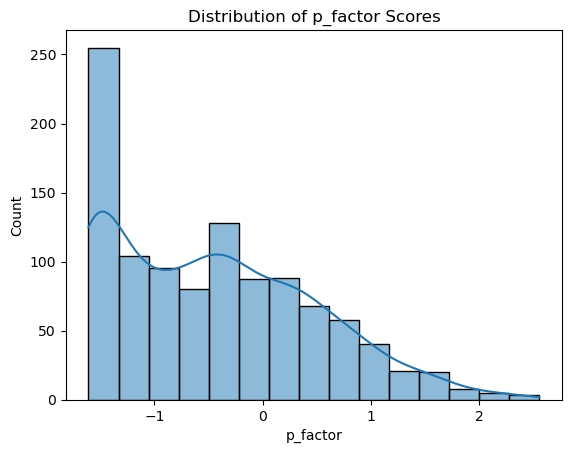

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_vars['p_factor'], kde=True)
plt.title("Distribution of p_factor Scores") ##negatively skewed, doesn't matter for ElasticNet?

### Univariate Relationships: Features vs. p_factor

In [ ]:
train_vars['sex'] = train_vars['sex'].map({'Female': 0, 'Male': 1})

/tmp/ipykernel_75/829337432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_vars['sex'] = train_vars['sex'].map({'Female': 0, 'Male': 1})


<Axes: >

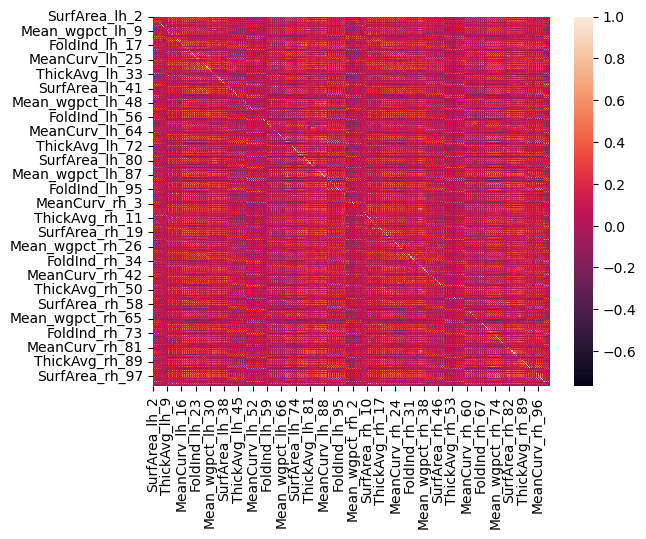

In [ ]:
train_vars_numeric = train_vars.drop(columns=['subject_id'])
sns.heatmap(train_vars_numeric.corr())

In [ ]:
train_vars_numeric = train_vars.drop(columns=['subject_id'])
# Step 2: Compute correlations with p_factor
correlations = train_vars_numeric.corr()['p_factor'].drop('p_factor')  # remove self-correlation
# Step 3: Sort by absolute correlation
top_correlated = correlations.abs().sort_values(ascending=False)
# Step 4: Show top N
print("Top correlated features with p_factor:")
print(top_correlated.head(10)) 

Top correlated features with p_factor:
age                   0.221855
ThickAvg_lh_99        0.194948
Mean_piallgi_rh_26    0.194804
GrayVol_lh_87         0.192949
Mean_piallgi_lh_52    0.188774
Mean_piallgi_rh_25    0.185185
GrayVol_lh_90         0.184861
ThickStd_lh_11        0.184722
ThickAvg_rh_100       0.184015
Mean_piallgi_lh_94    0.183541
Name: p_factor, dtype: float64
